In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import  kpss
import matplotlib as mpl
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

plt.rc('figure', figsize=(  10, 5))

### Import and preprocess data

In [3]:
# Load data from the drive (https://drive.google.com/drive/folders/1YrzUIwOvwenaq2DVtTzNyerna5aCreQE?usp=sharing)  and put it in the data folder
data = pd.read_csv('./data/household_power_consumption.csv')

data['DateAndTime'] = data['Date'].str.cat(data['Time'],sep=" ")
data['DateAndTime'] = pd.to_datetime(data['DateAndTime'], format="%Y-%m-%d %H:%M:%S")
data['month'] = data['DateAndTime'].dt.month
data['year']= data['DateAndTime'].dt.year
data = data.drop(['Date', 'Time'], axis=1)
data.set_index('DateAndTime',inplace=True)
data.head(2)

Global_active_power  Global_reactive_power  Voltage  \
DateAndTime                                                                
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
DateAndTime                                                             
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   

                     Sub_metering_3  month  year  
DateAndTime                                       
2006-12-16 17:24:00            17.0     12  2006  
2006-12-16 17:25:00            16.0     12  2006

In [36]:
#  agglomerate data by day and hour
data_daily = data.resample('D').mean()
data_daily.dropna(inplace=True)
data_hourly = data.resample('H').mean()
years = list(data_daily['year'].unique())[1:]

## Data Analysis

In [14]:
profile = ProfileReport(data_daily, title="hourly energy consumption", html={"style": {"full_width": True}})
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

To analyse our data , we will focus on these three features: Global_active_power, Voltage and Sub_metering_3 that have the most representative distributions


## Plot data

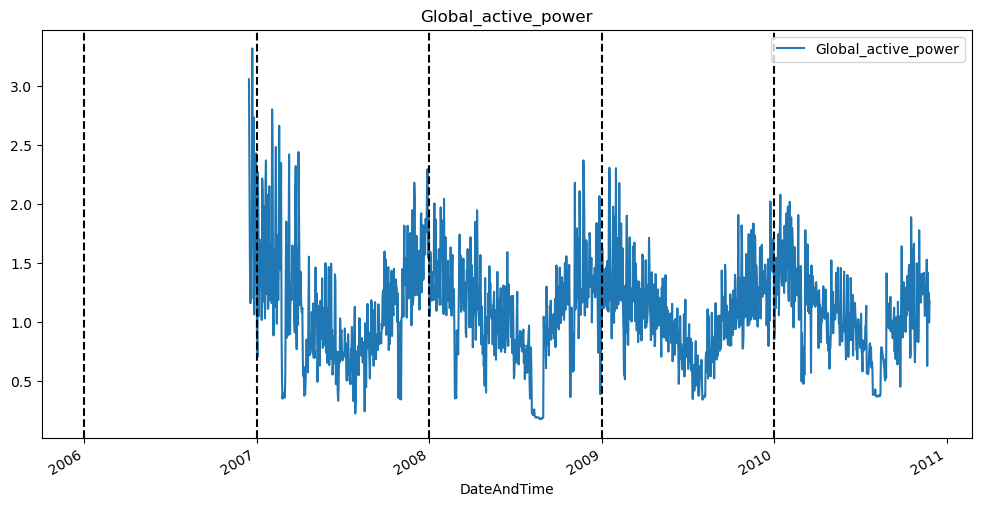

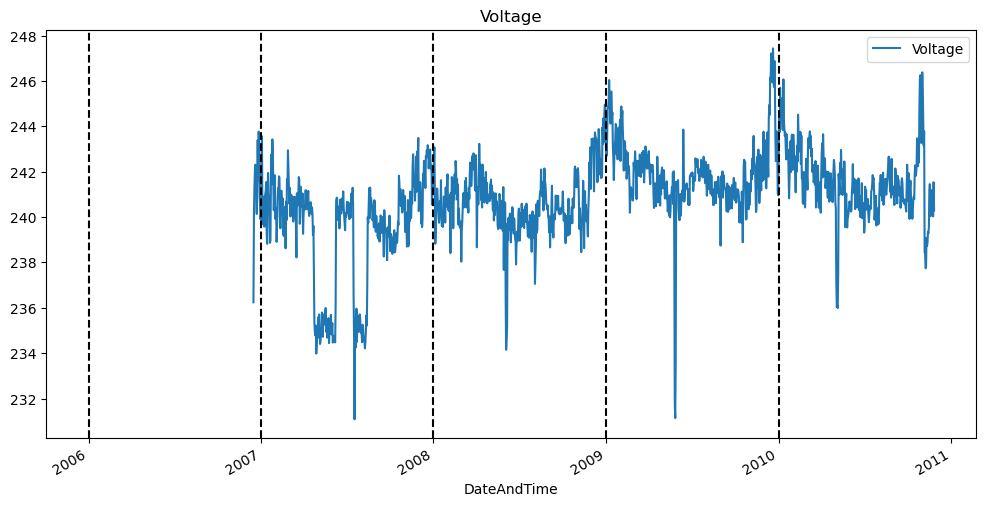

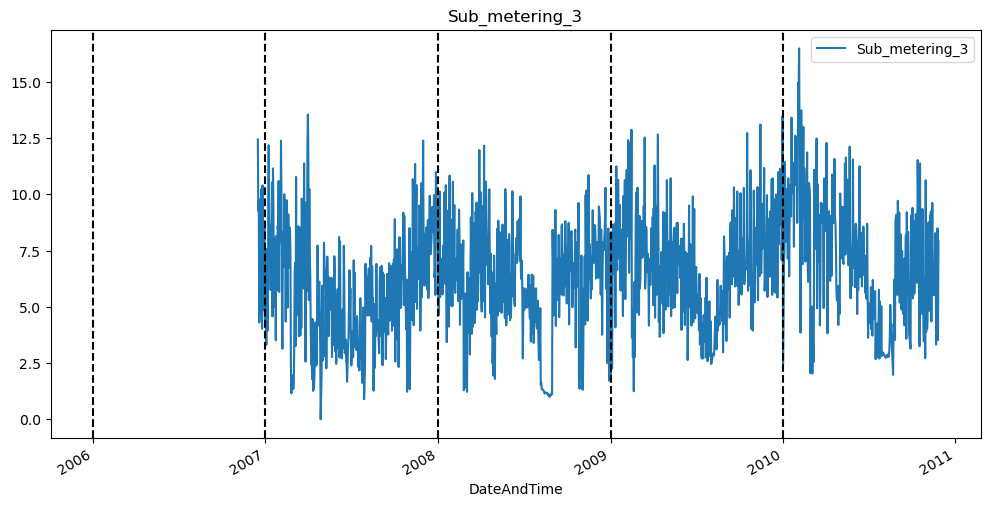

In [15]:
columns=['Global_active_power', 'Voltage', 'Sub_metering_3']
for col in columns:
    ax = data_daily.plot( y=col, figsize=(12,6))
    xcoords = ['2006-01-01', '2007-01-01','2008-01-01', '2009-01-01', '2010-01-01']
    plt.title(col)
    for xc in xcoords:
        plt.axvline(x=xc, color='black', linestyle='--')
        

Zooming by year

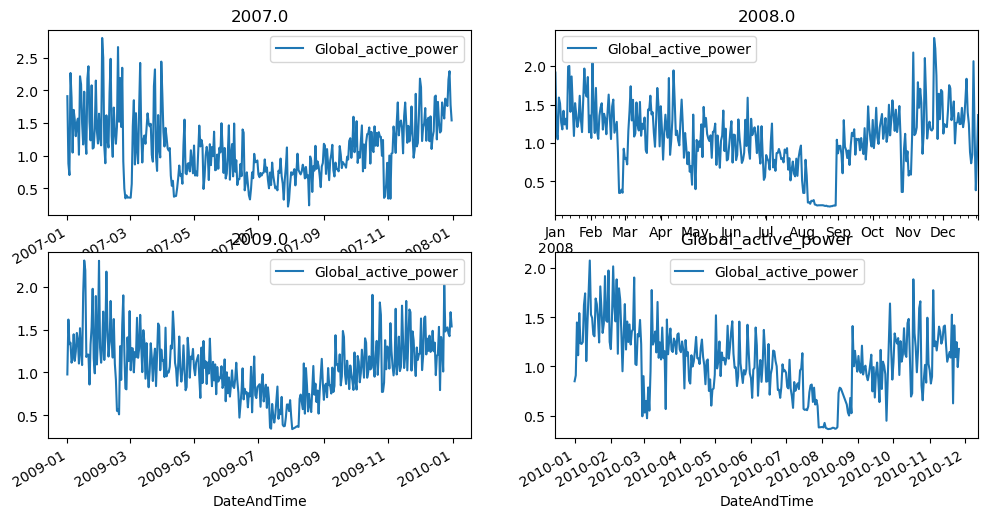

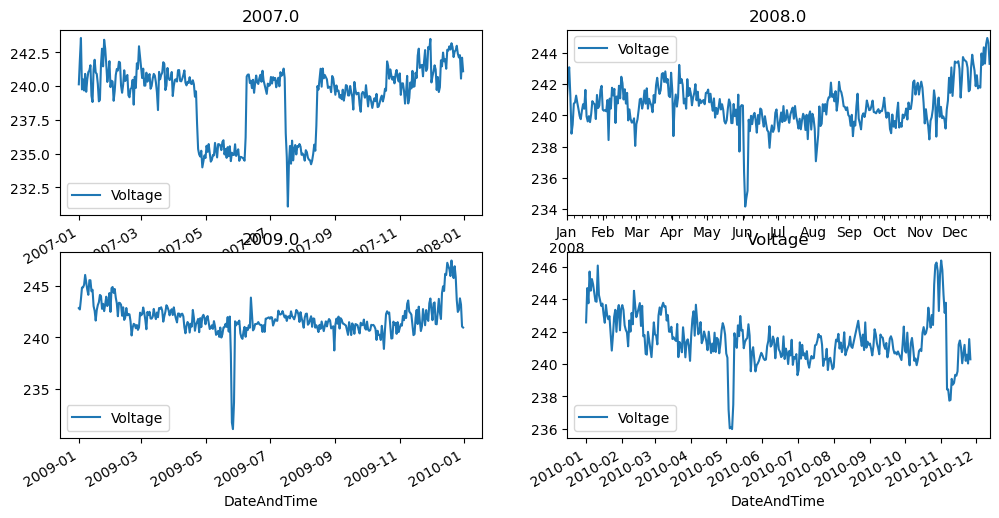

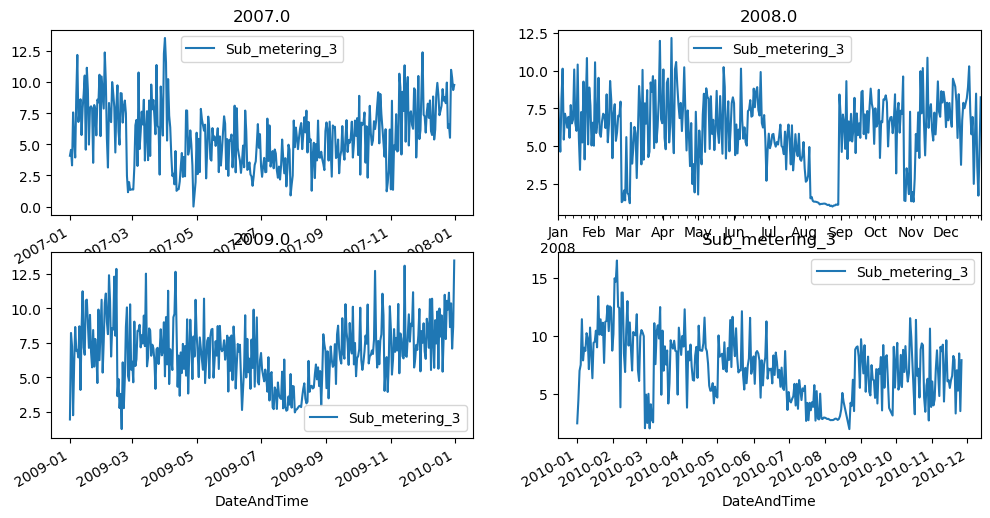

In [41]:
for col in columns:
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    for i in range(len(years[1:])+1):
        year = years[i]
        ax = data_daily[data_daily['year']==year].plot( y=col, ax=axes[i//2, i%2])
        ax.set_title(year)
    plt.title(col)
    plt.plot()

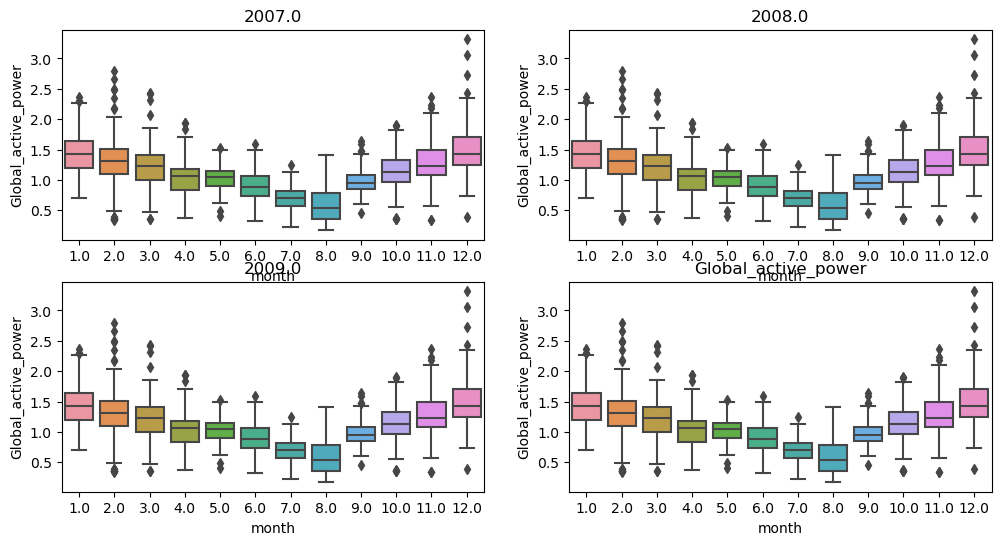

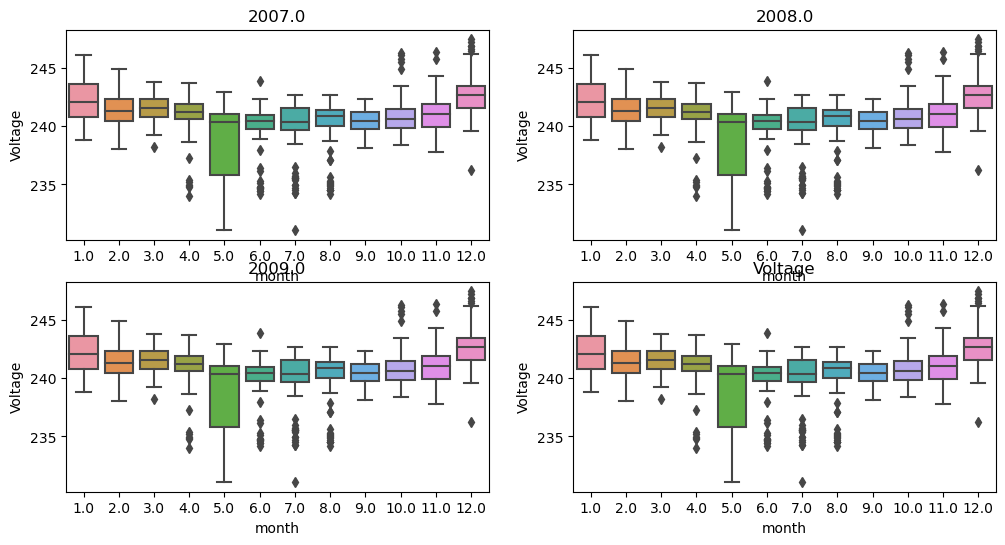

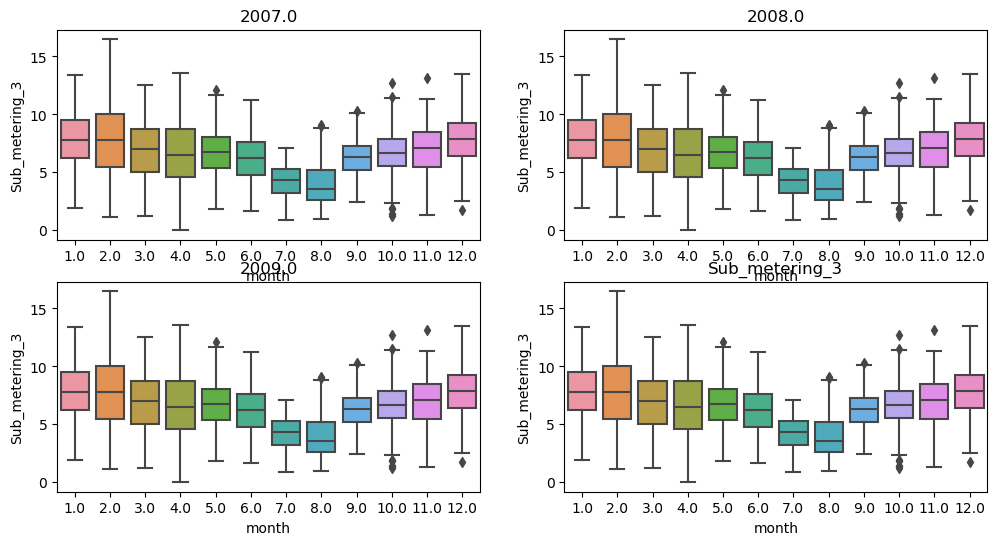

In [42]:
for col in columns:
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    for i in range(len(years[1:])+1):
        year = years[i]
        ax =sns.boxplot(x='month', y=col, data=data_daily, ax=axes[i//2, i%2])
        ax.set_title(year)
    plt.title(col)
    plt.plot()


We see here that Global_active_power has a trend where it decreases on the 8th month and then increases again. It has the highest values in January and December. Same trend can be seen for the Sub_metering_3 feature (february and december). For the Voltage feature, we have a decrease on the 5th month (May) and then it increases to have almost a stable idea during the whole year.


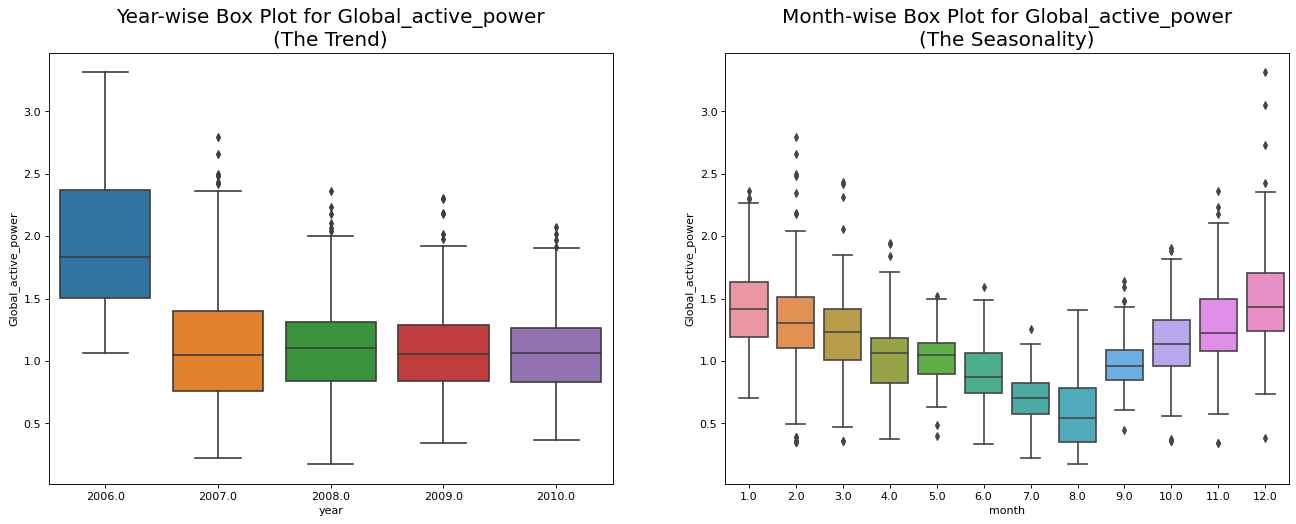

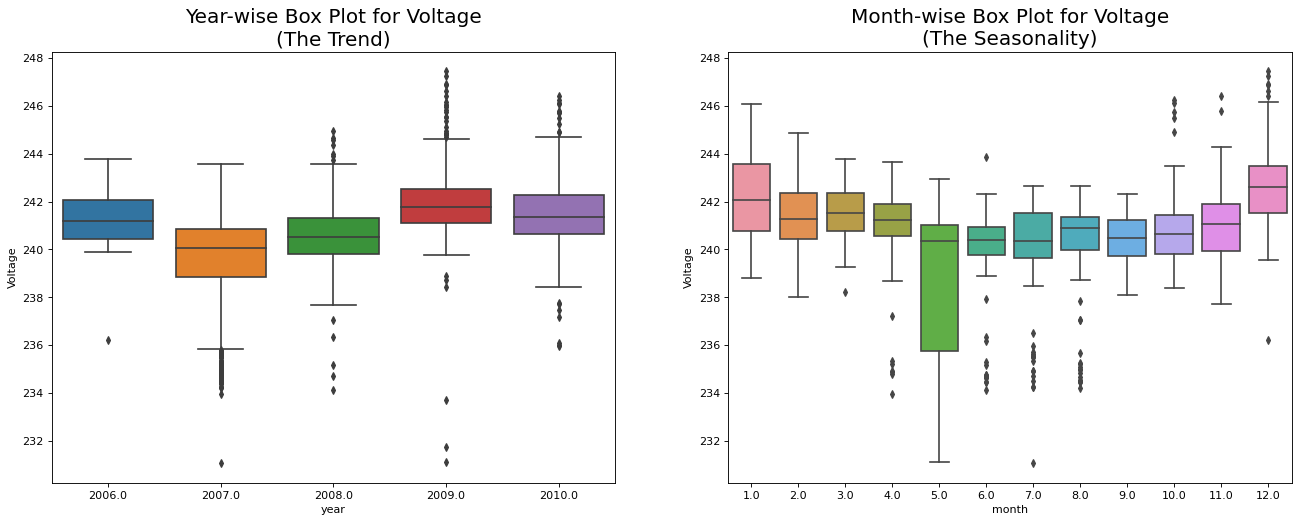

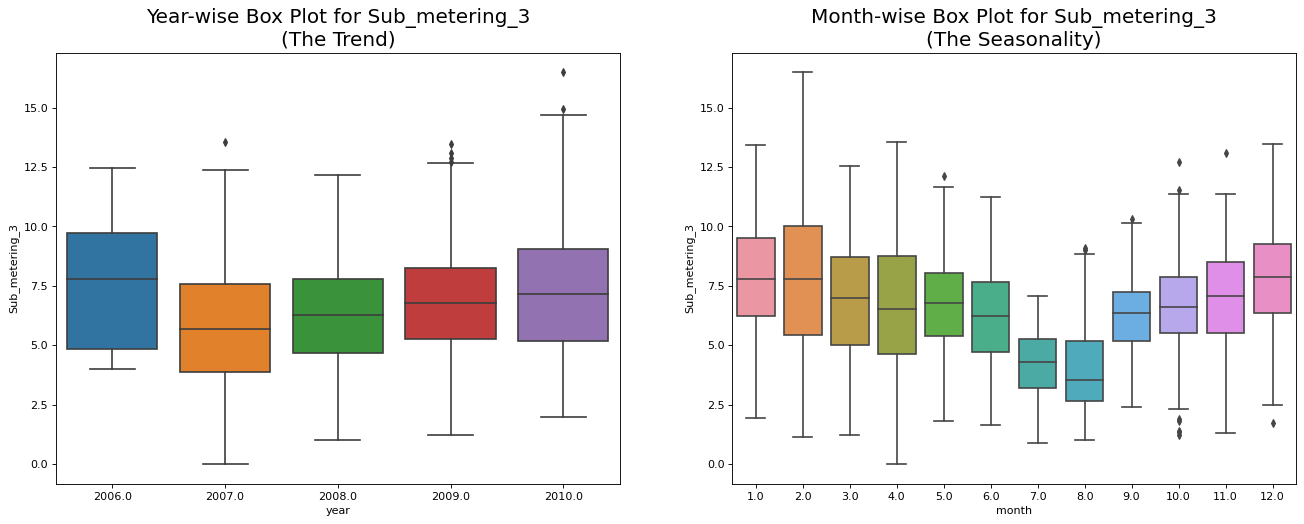

In [43]:
for col in columns: 
   # Draw Plot
    fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
    sns.boxplot(x='year', y=col, data=data_daily, ax=axes[0])
    sns.boxplot(x='month', y=col, data=data_daily, ax=axes[1])

    # Set Title
    axes[0].set_title('Year-wise Box Plot for '+col +'\n(The Trend)', fontsize=18); 
    axes[1].set_title('Month-wise Box Plot for '+col +'\n(The Seasonality)', fontsize=18)
    plt.show()

We observe that we have almost a constant trend by year and that we have an annual seasonality for the 3 features. It is crucial for when we split to include at least one complete year to take into consideration the monthly trend and the yearly seasonality

Checking for trend

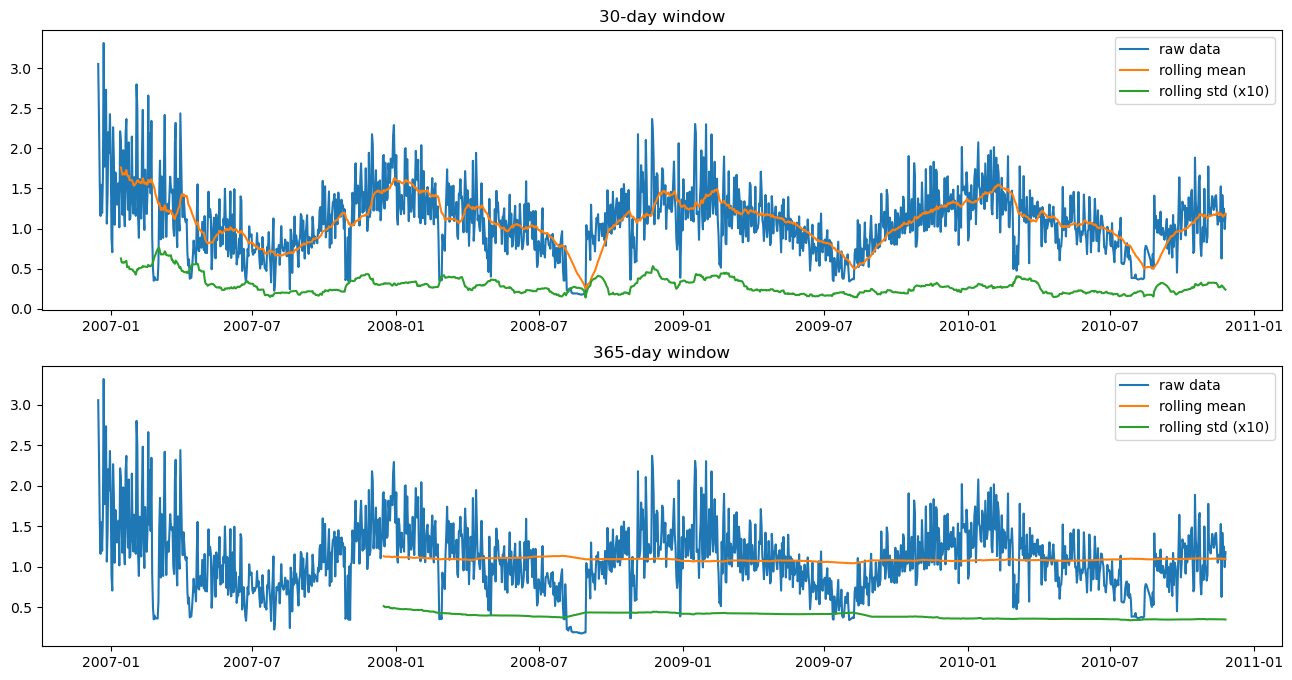

In [44]:

def analyze_stationarity(timeseries, title):
    fig, ax = plt.subplots(2, 1, figsize=(16, 8))

    rolmean = pd.Series(timeseries).rolling(window=30).mean() 
    rolstd = pd.Series(timeseries).rolling(window=30).std()
    ax[0].plot(timeseries, label= title)
    ax[0].plot(rolmean, label='rolling mean');
    ax[0].plot(rolstd, label='rolling std (x10)');
    ax[0].set_title('30-day window')
    ax[0].legend()
    
    rolmean = pd.Series(timeseries).rolling(window=365).mean() 
    rolstd = pd.Series(timeseries).rolling(window=365).std()
    ax[1].plot(timeseries, label= title)
    ax[1].plot(rolmean, label='rolling mean');
    ax[1].plot(rolstd, label='rolling std (x10)');
    ax[1].set_title('365-day window')
    ax[1].legend()

pd.options.display.float_format = '{:.8f}'.format
analyze_stationarity(data_daily['Global_active_power'], 'raw data')


Here we observe a monthly trend and a stationnary trend on the year level

In [84]:
dftest = adfuller(data_daily['Global_active_power'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Test Statistic                  -3.68422753
p-value                          0.00434056
#Lags Used                      22.00000000
Number of Observations Used   1410.00000000
Critical Value (1%)             -3.43499627
Critical Value (5%)             -2.86359200
Critical Value (10%)            -2.56786248
dtype: float64


p_value=0.00434056 <0.05 , we can refute the null hypothesis , the time series is not stationnary

source : https://towardsdatascience.com/time-series-forecasting-based-on-the-trend-and-seasonal-components-26b92866e548

In [86]:
def KPSS_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries.dropna(), regression="c", nlags="auto")    
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

KPSS_test(data_daily['Global_active_power'])

Results of KPSS Test:
Test Statistic           0.20777790
p-value                  0.10000000
Lags Used               23.00000000
Critical Value (10%)     0.34700000
Critical Value (5%)      0.46300000
Critical Value (2.5%)    0.57400000
Critical Value (1%)      0.73900000
dtype: float64


c:\Users\maram\anaconda3\envs\GPU_env\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


p-value=0.1 we cannot refute the null hypothesis , the time series is not stationnary

## These three results reinforce the observations made earlier about the trend

https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html